# Predictive models for lesion PI-RADS and the clinical significance (pycaret)

We will be exploring the use of radiomics for predicting the clinical significance of prostate lesions on mpMRI images.

Our data consists of mpMRI images and annotations prepared by three radiologists, as well as clinical information and biopsy results with International Society of Urological Pathology (ISUP) Gleason grading for each lesion. The radiologists annotated the data with multiple imaging features for each lesion, using the assessment algorithm from the PI-RADS standard.

To verify the hypotheses, we will be using a supervised learning algorithm to train a model on the mpMRI images and the biopsy results. We use extracted radiomics features and use cross-validation to assess the performance of the model, and visualize the results using a receiver operating characteristic (ROC) curve.

Interesting targets:

Clinical Significance
'TBx'

PI-RADS values:
'lesion_t2w_pz',
'lesion_t2w_tz', 
'lesion_dwi', 
'lesion_dce', 
'lesion_pirads',
'patient_pirads', 
'lesion_t2w_pz_cat', 
'lesion_t2w_tz_cat',
'lesion_dwi_cat'



Let's begin by importing the necessary libraries and loading the data.

In [1]:
#!pip install --no-cache-dir pycaret

In [2]:
import sys 
import os 
# Setup the notebook
%load_ext autoreload
%autoreload 2

# Add src to path

if os.path.basename(os.getcwd()) != 'ai4ar-radiomics':
    os.chdir('..')

if 'src' not in sys.path:
    sys.path.append('src')

from config import config # For reading the config files

cfg = config(
    ('json', 'config/config.json', True),
    ('json', 'config/config-ext.json', True),
    ignore_missing_paths = True
)

In [3]:
import ai4ar # AI4AR Helper package

import pandas as pd # For saving the features
from pycaret.classification import *

# Print the confusion matrix for the test set
from sklearn.metrics import confusion_matrix

# Print the classification report for the test set
from sklearn.metrics import classification_report

In [4]:
# Load the dataset
dataset = ai4ar.Dataset(cfg['data_dir'])

seed = 1991


train_test_ratio = 3/4

# Add T2W pirads category
dataset.radiological_metadata['lesion_t2w_cat'] = dataset.radiological_metadata['lesion_t2w_pz_cat'].fillna('') + dataset.radiological_metadata['lesion_t2w_tz_cat'].fillna('')
dataset.radiological_metadata['lesion_t2w'] = dataset.radiological_metadata['lesion_t2w_pz'].fillna(0) + dataset.radiological_metadata['lesion_t2w_tz'].fillna(0)

# Randomly slect 30% of the dataset for testing, and 70% for training

patients = dataset.radiological_metadata['patient_id'].unique()
np.random.seed(seed) 
train_msk = np.random.rand(len(patients)) < train_test_ratio

train_metadata = dataset.radiological_metadata[dataset.radiological_metadata['patient_id'].isin(patients[train_msk])]
test_metadata = dataset.radiological_metadata[~dataset.radiological_metadata['patient_id'].isin(patients[train_msk])]

# Load the extracted radiomics features
t2w_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_t2w.csv'))
# Load the extracted radiomics features
adc_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_adc.csv'))
# Load the extracted radiomics features
hbv_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_hbv.csv'))
# Load the extracted radiomics features
dce_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_dce3.csv'))

# Add infor about the source modality to the features
for mod, df in zip(['t2w','hbv','adc','dce'], [t2w_features, hbv_features, adc_features, dce_features]):
    df.rename(columns={col: f'{col}_{mod}' for col in df.columns if 'original_' in col}, inplace=True)
    

# IDX columns
idx_cols = ['patient_id', 'lesion_id', 'radiologist_id']  

In [5]:
len(train_metadata)

820

In [6]:
len(test_metadata)

256

In [7]:
train_metadata.head(5)

,patient_id,radiologist_id,lesion_id,TBx,dimension,lesion_dim_sequence,lesion_sectors,lesion_sectors_simple,lesion_zones,lesion_originating,lesion_side,lesion_t2w_pz,lesion_t2w_tz,lesion_dwi,lesion_dce,lesion_pirads,patient_pirads,lesion_t2w_pz_cat,lesion_t2w_tz_cat,lesion_dwi_cat,label_adc,label_cor,label_hbv,label_sag,label_t2w,label_dce1,label_dce2,label_dce3,label_dce4,label_dce5,label_dce6,lesion_t2w_cat,lesion_t2w
0,1,U_OjmNZ8,1,0,16.0,T2W,"AS-left-in-mid,TZa-left-in-mid","AS,TZa","AS,TZ",TZ,LEFT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5b,5a,lesion_labels/lesion1/adc/OjmNZ8,NaN,lesion_labels/lesion1/hbv/OjmNZ8,NaN,lesion_labels/lesion1/t2w/OjmNZ8,NaN,NaN,NaN,NaN,NaN,NaN,5b,5.0
1,1,U_8ZmM76,1,0,29.0,T2W,"AS-right-in-base,TZa-right-in-base,AS-left-in-...","AS,TZa","AS,TZ",TZ,RIGHT LEFT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/8ZmM76,NaN,lesion_labels/lesion1/hbv/8ZmM76,NaN,lesion_labels/lesion1/t2w/8ZmM76,NaN,NaN,NaN,NaN,NaN,NaN,5a,5.0
2,1,U_OrjnrO,1,0,31.0,T2W,"AS-left-in-apex,AS-left-in-mid,AS-right-in-mid...",AS,AS,TZ,LEFT RIGHT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5b,5a,lesion_labels/lesion1/adc/OrjnrO,NaN,lesion_labels/lesion1/hbv/OrjnrO,NaN,lesion_labels/lesion1/t2w/OrjnrO,NaN,NaN,lesion_labels/lesion1/dce3/OrjnrO,NaN,NaN,NaN,5b,5.0
3,3,U_8ekGLQ,1,1,18.0,ADC,"AS-left-in-base,TZa-left-in-base,TZa-left-in-mid","AS,TZa","AS,TZ",TZ,LEFT,NaN,5.0,5.0,1.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/8ekGLQ,NaN,lesion_labels/lesion1/hbv/8ekGLQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a,5.0
4,3,U_OjmNZ8,1,1,15.0,ADC,"TZa-left-in-base,TZa-left-in-mid,AS-left-in-base","TZa,AS","TZ,AS",TZ,LEFT,NaN,5.0,5.0,1.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/OjmNZ8,NaN,lesion_labels/lesion1/hbv/OjmNZ8,NaN,NaN,NaN,NaN,lesion_labels/lesion1/dce3/OjmNZ8,NaN,NaN,NaN,5a,5.0


In [8]:
train_metadata.columns

Index(['patient_id', 'radiologist_id', 'lesion_id', 'TBx', 'dimension',
       'lesion_dim_sequence', 'lesion_sectors', 'lesion_sectors_simple',
       'lesion_zones', 'lesion_originating', 'lesion_side', 'lesion_t2w_pz',
       'lesion_t2w_tz', 'lesion_dwi', 'lesion_dce', 'lesion_pirads',
       'patient_pirads', 'lesion_t2w_pz_cat', 'lesion_t2w_tz_cat',
       'lesion_dwi_cat', 'label_adc', 'label_cor', 'label_hbv', 'label_sag',
       'label_t2w', 'label_dce1', 'label_dce2', 'label_dce3', 'label_dce4',
       'label_dce5', 'label_dce6', 'lesion_t2w_cat', 'lesion_t2w'],
      dtype='object')

In [9]:
t2w_features.head()

,patient_id,lesion_id,radiologist_id,mask_path,data_path,original_firstorder_10Percentile_t2w,original_firstorder_90Percentile_t2w,original_firstorder_Energy_t2w,original_firstorder_Entropy_t2w,original_firstorder_InterquartileRange_t2w,original_firstorder_Kurtosis_t2w,original_firstorder_Maximum_t2w,original_firstorder_MeanAbsoluteDeviation_t2w,original_firstorder_Mean_t2w,original_firstorder_Median_t2w,original_firstorder_Minimum_t2w,original_firstorder_Range_t2w,original_firstorder_RobustMeanAbsoluteDeviation_t2w,original_firstorder_RootMeanSquared_t2w,original_firstorder_Skewness_t2w,original_firstorder_TotalEnergy_t2w,original_firstorder_Uniformity_t2w,original_firstorder_Variance_t2w,original_glcm_Autocorrelation_t2w,original_glcm_ClusterProminence_t2w,original_glcm_ClusterShade_t2w,original_glcm_ClusterTendency_t2w,original_glcm_Contrast_t2w,original_glcm_Correlation_t2w,original_glcm_DifferenceAverage_t2w,original_glcm_DifferenceEntropy_t2w,original_glcm_DifferenceVariance_t2w,original_glcm_Id_t2w,original_glcm_Idm_t2w,original_glcm_Idmn_t2w,original_glcm_Idn_t2w,original_glcm_Imc1_t2w,original_glcm_Imc2_t2w,original_glcm_InverseVariance_t2w,original_glcm_JointAverage_t2w,original_glcm_JointEnergy_t2w,original_glcm_JointEntropy_t2w,original_glcm_MCC_t2w,original_glcm_MaximumProbability_t2w,original_glcm_SumAverage_t2w,original_glcm_SumEntropy_t2w,original_glcm_SumSquares_t2w
0,1,1,U_OjmNZ8,lesion_labels/lesion1/t2w/OjmNZ8,data/t2w,95.0,159.0,3410783.0,2.248859,32.00,5.322890,227.0,21.785000,127.145000,127.5,6.0,221.0,14.030864,130.590639,-0.370589,1.082524e+07,0.264900,888.063975,32.293005,35.776776,-0.187163,2.797860,2.351875,0.086186,1.079460,1.904280,1.179326,0.609136,0.574963,0.978653,0.910431,-0.084887,0.549885,0.475830,5.672836,0.084822,4.116675,0.442936,0.147789,11.345671,2.699190,1.287434
1,1,1,U_8ZmM76,lesion_labels/lesion1/t2w/8ZmM76,data/t2w,83.0,161.0,18951780.0,2.436913,40.00,4.546336,270.0,25.262647,123.428818,126.0,0.0,270.0,16.605125,127.874305,-0.617128,6.014969e+07,0.226218,1117.164692,30.837574,48.771239,-2.971511,3.474053,2.993997,0.074468,1.300342,2.058430,1.289160,0.552497,0.504604,0.977182,0.901438,-0.033446,0.374144,0.468826,5.542182,0.060359,4.592517,0.239668,0.117783,11.084365,2.883047,1.617012
2,1,1,U_OrjnrO,lesion_labels/lesion1/t2w/OrjnrO,data/t2w,79.0,164.1,28481031.0,2.572456,44.00,4.571548,305.0,27.464452,123.463372,125.0,0.0,305.0,18.182307,128.680764,-0.125049,9.039389e+07,0.206492,1315.534705,30.357475,55.068221,-1.437511,3.881512,3.703067,0.025536,1.453161,2.182675,1.572226,0.526755,0.471751,0.979695,0.905787,-0.024875,0.331395,0.448691,5.505017,0.049960,4.861650,0.202465,0.104634,11.010035,2.987150,1.896145
3,3,1,U_8ZmM76,lesion_labels/lesion1/t2w/8ZmM76,data/t2w,63.0,201.0,2243638.0,3.056317,57.00,3.340976,286.0,41.261253,125.123967,115.0,8.0,278.0,27.283027,136.170712,0.634257,4.263823e+06,0.148009,2886.455707,29.189453,299.306654,16.623860,9.016457,7.338745,0.100625,2.086850,2.551521,2.949324,0.448228,0.373827,0.955844,0.863637,-0.158844,0.778955,0.369224,5.363399,0.030463,5.458917,0.482515,0.074127,10.726799,3.440320,4.088800
4,3,2,U_8ekGLQ,lesion_labels/lesion2/t2w/8ekGLQ,data/t2w,26.0,153.9,5056339.0,2.897668,67.75,2.874104,289.0,38.450543,90.657676,93.0,0.0,289.0,27.531955,102.422311,0.111455,9.609097e+06,0.146270,2271.515595,16.689695,131.985389,1.423610,7.115450,7.866815,-0.018507,2.245563,2.542368,2.533083,0.419999,0.337045,0.951980,0.853524,-0.084616,0.589371,0.340918,4.101640,0.025578,5.515494,0.359564,0.050298,8.203280,3.370117,3.745566


In [10]:
def prepare_input(metadata, features, target):
        

    radiomic_cols = [ col for col in features.columns if 'original_' in col]
    
    # Merge the features and the metadata
    input = metadata.merge(features, on=idx_cols, how='left')
    
    # Adding fold groups (patient_id) - groupping is important for the cross validation as we want to keep the same patient in the same fold
    input = input[[*radiomic_cols, 'patient_id', target]]
    # Filter na 
    input = input[~input[target].isin(['na','x','X'])]
    input = input[~input[target].isna()]
    input[target] = input[target].astype(int)
    
    return input


def setup_pycaret(train, target):
    return setup(
        data = train, 
        target = target,
        session_id=seed,
        fold_strategy='groupkfold',
        fold_groups='patient_id', # Group by patient_id, so that the same patient is not in different folds
        normalize=True,
        transformation=False,
        feature_selection=True,
        ignore_low_variance=True,
        remove_multicollinearity=True, 
        silent=True, # Otherwise it will ask for input
        multicollinearity_threshold=0.95
    )

In [11]:
considered_models = ['lr', 'ridge', 'lda', 'qda', 'svm']

## DCE - PIRADS


Predicting the DCE PI-RADS score (+/-) based on the DCE radiomic features

In [12]:
target = 'lesion_dce'

train = prepare_input(train_metadata, dce_features, target)
test = prepare_input(test_metadata, dce_features, target)


In [13]:
len(train)

852

In [14]:
#!pip install --force --no-cache-dir scikit-learn==0.23.2

In [15]:
clfs = setup_pycaret(train, target)

,Description,Value
0,session_id,1991
1,Target,lesion_dce
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(852, 44)"
5,Missing Values,True
6,Numeric Features,43
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
print('Removed features:\n\t', ', '.join(set(train.columns)-set(get_config('X_train').columns)))

print('\n\nSelected features:\n\t', ', '.join(set(get_config('X_train').columns)))

Removed features:
	 original_firstorder_MeanAbsoluteDeviation_dce, original_firstorder_RootMeanSquared_dce, original_glcm_DifferenceEntropy_dce, original_glcm_JointAverage_dce, original_firstorder_Mean_dce, original_firstorder_Uniformity_dce, original_glcm_ClusterTendency_dce, original_glcm_SumAverage_dce, original_glcm_Idn_dce, original_glcm_Idm_dce, original_glcm_JointEnergy_dce, original_glcm_Id_dce, original_glcm_SumSquares_dce, original_firstorder_TotalEnergy_dce, original_glcm_DifferenceAverage_dce, original_firstorder_RobustMeanAbsoluteDeviation_dce, lesion_dce, original_glcm_MCC_dce, original_glcm_Contrast_dce, original_glcm_JointEntropy_dce, original_glcm_SumEntropy_dce, original_glcm_DifferenceVariance_dce


Selected features:
	 original_firstorder_Energy_dce, original_glcm_Idmn_dce, original_glcm_ClusterProminence_dce, original_glcm_InverseVariance_dce, original_glcm_Imc1_dce, original_glcm_Autocorrelation_dce, original_firstorder_Variance_dce, original_firstorder_Maximum_dc

AutoML best model

In [17]:
top3 = compare_models(n_select=3, sort='AUC', include=considered_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.8507,0.8363,0.8894,0.9063,0.8969,0.6141,0.6189,0.0040
lr,Logistic Regression,0.7229,0.5569,0.9818,0.7327,0.8376,-0.0255,-0.0536,0.4130
lda,Linear Discriminant Analysis,0.7212,0.5522,0.9797,0.7323,0.8365,-0.0284,-0.0567,0.0050
ridge,Ridge Classifier,0.7279,0.0000,0.9888,0.7340,0.8410,-0.0157,-0.0298,0.0040
svm,SVM - Linear Kernel,0.5971,0.0000,0.7751,0.7041,0.7360,-0.1421,-0.1487,0.0040


In [18]:
tuned_top3 = [tune_model(i, optimize='AUC', n_iter=25) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8667,0.6466,1.0000,0.8667,0.9286,0.0000,0.0000
1,0.7833,0.6187,1.0000,0.7833,0.8785,0.0000,0.0000
2,0.7500,0.5171,0.9783,0.7627,0.8571,-0.0321,-0.0718
3,0.7500,0.5668,0.9783,0.7627,0.8571,-0.0321,-0.0718
4,0.6667,0.6072,0.9756,0.6780,0.8000,-0.0327,-0.0886
5,0.7167,0.5096,0.9556,0.7414,0.8350,-0.0625,-0.1072
6,0.7458,0.6379,1.0000,0.7458,0.8544,0.0000,0.0000
7,0.6441,0.5739,1.0000,0.6441,0.7835,0.0000,0.0000
8,0.6780,0.4928,1.0000,0.6780,0.8081,0.0000,0.0000


In [19]:
#blender = blend_models(tuned_top3)
#stacker = stack_models(tuned_top3) 

In [20]:
best_model = automl(optimize='AUC')

In [21]:
best_model

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [22]:
#plot_model(best_model, plot = 'learning', groups='patient_id')

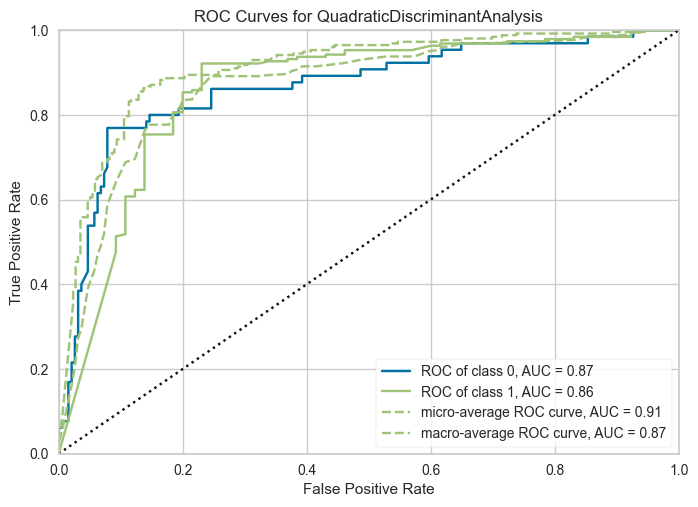

In [23]:
plot_model(best_model, plot = 'auc')

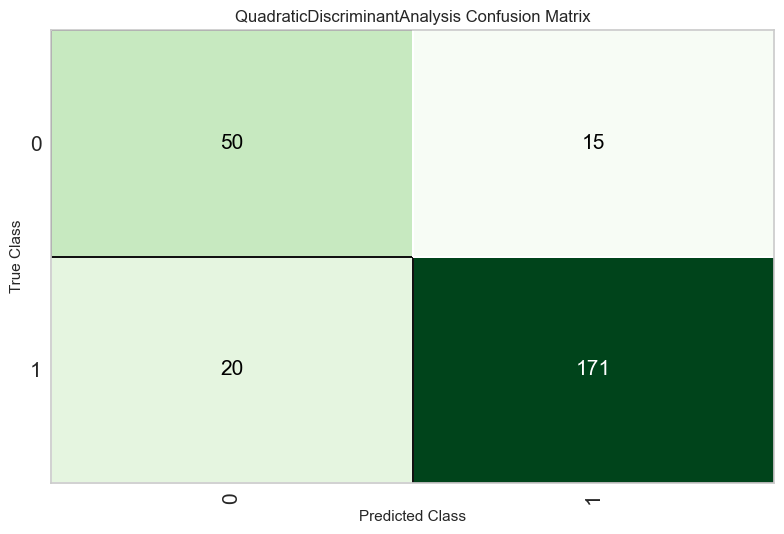

In [24]:
plot_model(best_model, plot = 'confusion_matrix')

In [25]:
try:
    plot_model(best_model, plot = 'feature_all')
except:
    print('Feature importance not available for this model')

Feature importance not available for this model


### Evaluation on the test data

In [26]:
final_best_model = finalize_model(best_model)
predictions = predict_model(final_best_model, data = test, round = 3, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.826,0.819,0.859,0.907,0.882,0.550,0.553


In [27]:
print("classification report")
print(classification_report(predictions[target], predictions['Label']))
# Format the confusion matrix to be more readable 
cm = confusion_matrix(predictions[target], predictions['Label'])
pd.DataFrame(cm, columns=[f'Predicted {i}' for i in range(cm.shape[0])], index=[f'Actual {i}' for i in range(cm.shape[1])])

classification report
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        61
           1       0.91      0.86      0.88       192

    accuracy                           0.83       253
   macro avg       0.76      0.79      0.77       253
weighted avg       0.84      0.83      0.83       253



,Predicted 0,Predicted 1
Actual 0,44,17
Actual 1,27,165


## DWI (HBV) / ADC - PIRADS

Predicting the DWI/ADC PI-RADS score (0-5) based on the DWI and ADC radiomic features

In [28]:
target = 'lesion_dwi'

radiomic_dwi = hbv_features.merge(adc_features, on=idx_cols, how='left', suffixes=('_hbv', '_adc'))

train = prepare_input(train_metadata, radiomic_dwi, target)
test = prepare_input(test_metadata, radiomic_dwi, target)

In [29]:
train.columns

Index(['original_firstorder_10Percentile_hbv',
       'original_firstorder_90Percentile_hbv',
       'original_firstorder_Energy_hbv', 'original_firstorder_Entropy_hbv',
       'original_firstorder_InterquartileRange_hbv',
       'original_firstorder_Kurtosis_hbv', 'original_firstorder_Maximum_hbv',
       'original_firstorder_MeanAbsoluteDeviation_hbv',
       'original_firstorder_Mean_hbv', 'original_firstorder_Median_hbv',
       'original_firstorder_Minimum_hbv', 'original_firstorder_Range_hbv',
       'original_firstorder_RobustMeanAbsoluteDeviation_hbv',
       'original_firstorder_RootMeanSquared_hbv',
       'original_firstorder_Skewness_hbv',
       'original_firstorder_TotalEnergy_hbv',
       'original_firstorder_Uniformity_hbv',
       'original_firstorder_Variance_hbv', 'original_glcm_Autocorrelation_hbv',
       'original_glcm_ClusterProminence_hbv', 'original_glcm_ClusterShade_hbv',
       'original_glcm_ClusterTendency_hbv', 'original_glcm_Contrast_hbv',
       'origina

In [30]:
clfs = setup_pycaret(train, target)

,Description,Value
0,session_id,1991
1,Target,lesion_dwi
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1018, 86)"
5,Missing Values,True
6,Numeric Features,84
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [31]:
print('Removed features:\n\t', ', '.join(set(train.columns)-set(get_config('X_train').columns)))

print('\n\nSelected features:\n\t', ', '.join(set(get_config('X_train').columns)))

Removed features:
	 original_firstorder_RobustMeanAbsoluteDeviation_hbv, original_glcm_Idmn_hbv, original_glcm_DifferenceEntropy_adc, original_firstorder_TotalEnergy_adc, original_firstorder_90Percentile_hbv, original_firstorder_Variance_adc, original_glcm_DifferenceVariance_hbv, original_glcm_Idn_adc, original_glcm_Idn_hbv, original_firstorder_RootMeanSquared_adc, original_glcm_JointAverage_hbv, lesion_dwi, original_glcm_SumAverage_hbv, original_firstorder_Entropy_hbv, original_firstorder_Energy_hbv, original_firstorder_Maximum_hbv, original_glcm_DifferenceAverage_adc, original_glcm_JointAverage_adc, original_glcm_Contrast_hbv, original_glcm_SumSquares_hbv, original_glcm_MaximumProbability_hbv, original_glcm_JointEnergy_hbv, original_glcm_SumEntropy_hbv, original_glcm_JointEntropy_hbv, original_glcm_Idm_hbv, original_glcm_Id_adc, original_glcm_MaximumProbability_adc, original_firstorder_MeanAbsoluteDeviation_hbv, original_glcm_SumSquares_adc, original_glcm_InverseVariance_hbv, origina

Select models

In [32]:
top3 = compare_models(n_select=3, sort='Accuracy', include=considered_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7781,0.0000,0.4746,0.7519,0.7601,0.5893,0.5943,0.0190
ridge,Ridge Classifier,0.7739,0.0000,0.4329,0.7206,0.7436,0.5738,0.5821,0.0040
lda,Linear Discriminant Analysis,0.7275,0.0000,0.4383,0.7620,0.7369,0.5333,0.5410,0.0040
svm,SVM - Linear Kernel,0.7248,0.0000,0.4103,0.7152,0.7160,0.5009,0.5063,0.0260


In [33]:
tuned_top3 = [tune_model(i) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8056,0.0000,0.5385,0.8200,0.8106,0.6337,0.6361
1,0.7917,0.0000,0.4781,0.7687,0.7705,0.5985,0.6037
2,0.6761,0.0000,0.3843,0.6098,0.6401,0.4191,0.4257
3,0.7465,0.0000,0.4575,0.7693,0.7343,0.5361,0.5436
4,0.7887,0.0000,0.7516,0.8174,0.7932,0.6274,0.6397
5,0.7746,0.0000,0.3386,0.7459,0.7580,0.5979,0.6019
6,0.7606,0.0000,0.3324,0.7289,0.7440,0.5721,0.5743
7,0.7042,0.0000,0.3879,0.6742,0.6849,0.4642,0.4703
8,0.7746,0.0000,0.3344,0.7376,0.7530,0.5846,0.5902


In [34]:
best_model = automl(optimize='Accuracy')

In [35]:
best_model

RidgeClassifier(alpha=6.12, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1991,
                solver='auto', tol=0.001)

In [36]:
#plot_model(best_model, plot = 'learning', groups='fold_group')

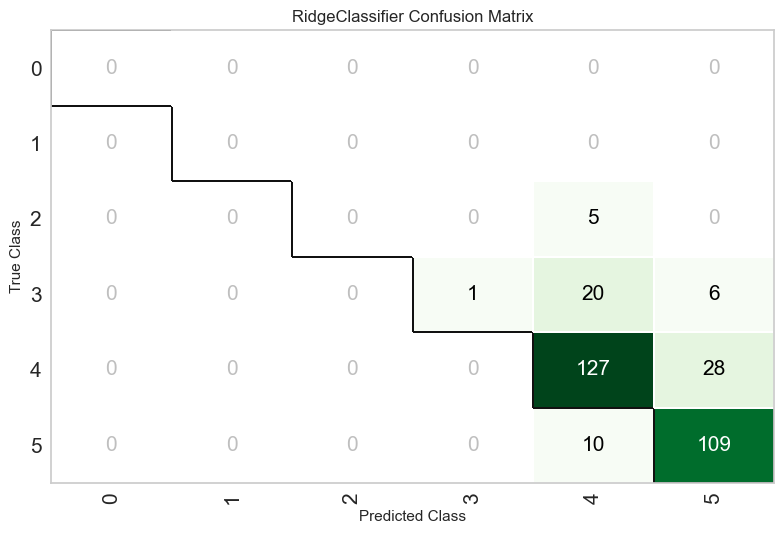

In [37]:
plot_model(best_model, plot = 'confusion_matrix')

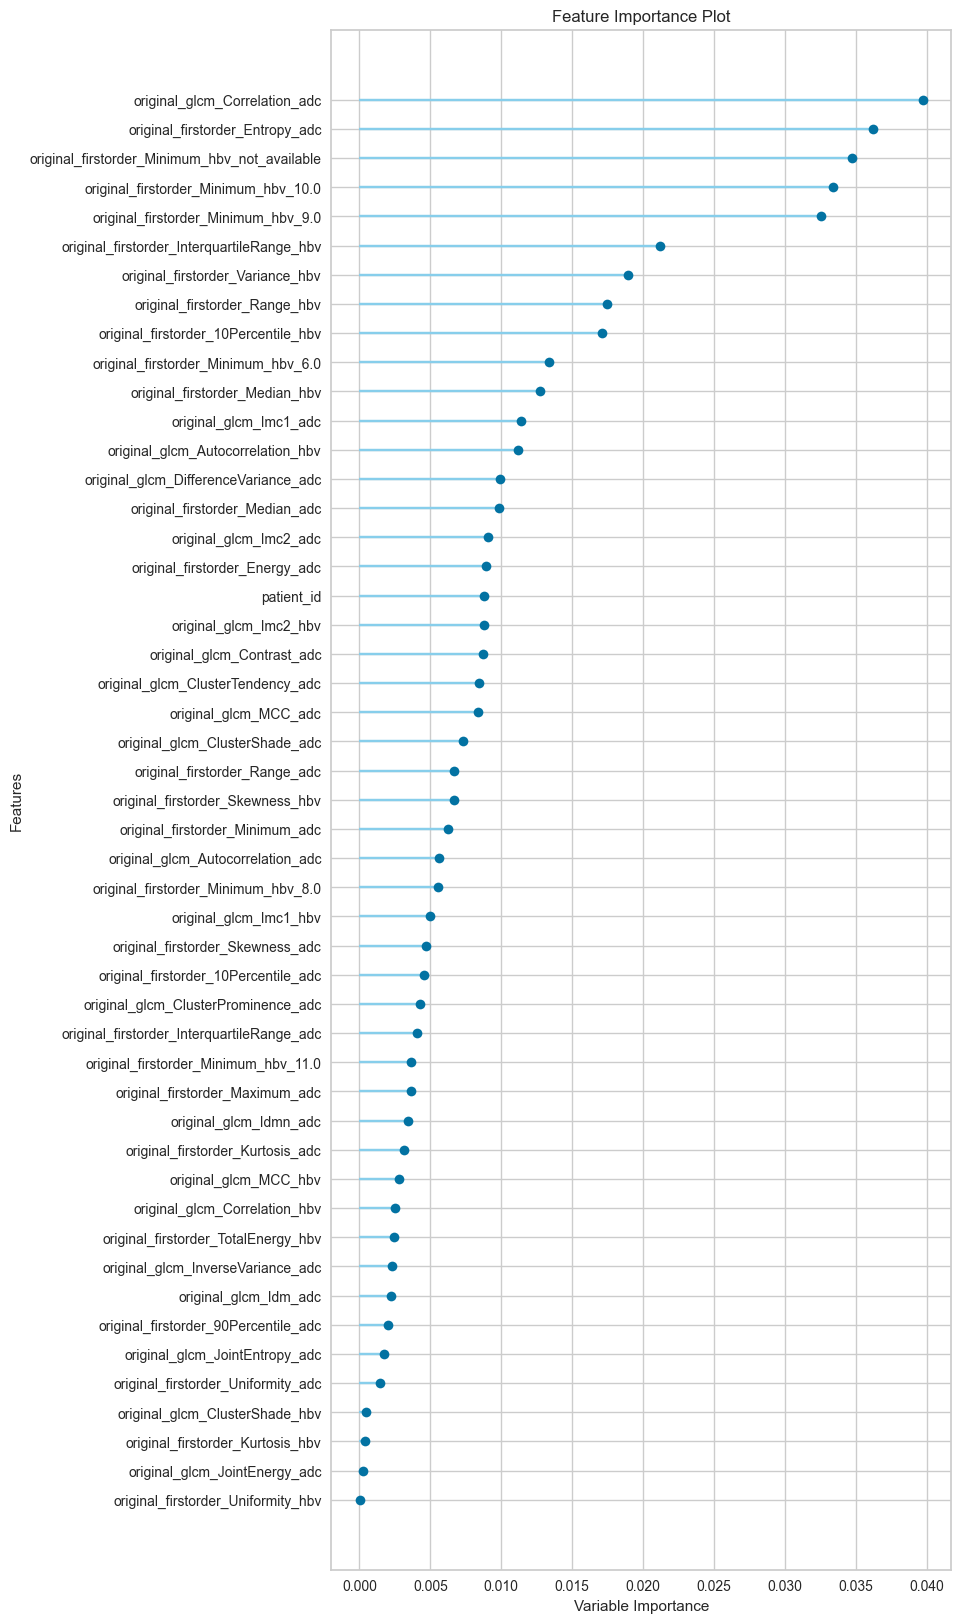

In [38]:
try:
    plot_model(best_model, plot = 'feature_all')
except:
    print('Feature importance not available for this model')

### Evaluation on the test data

In [39]:
final_best_model = finalize_model(best_model)
predictions = predict_model(final_best_model, data = test, round = 3, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.768,0,0.350,0.665,0.712,0.554,0.574


In [40]:
print("classification report")
print(classification_report(predictions[target], predictions['Label']))
# Format the confusion matrix to be more readable 
cm = confusion_matrix(predictions[target], predictions['Label'])
pd.DataFrame(cm, columns=[f'Predicted {i}' for i in range(cm.shape[0])], index=[f'Actual {i}' for i in range(cm.shape[1])])

classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        32
           4       0.76      0.91      0.83       160
           5       0.78      0.84      0.81        86

    accuracy                           0.77       284
   macro avg       0.31      0.35      0.33       284
weighted avg       0.67      0.77      0.71       284



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,0,0,1,1
Actual 1,0,0,0,3,1
Actual 2,0,0,0,28,4
Actual 3,0,0,0,146,14
Actual 4,0,0,0,14,72


## T2W PIRADS

Predicting the T2W PI-RADS score (0-5) based on the T2W radiomic features

### PZ 

In [41]:
target = 'lesion_t2w_pz'

train = prepare_input(train_metadata, t2w_features, target)
test = prepare_input(test_metadata, t2w_features, target)

In [42]:
clfs = setup_pycaret(train, target)

,Description,Value
0,session_id,1991
1,Target,lesion_t2w_pz
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(428, 44)"
5,Missing Values,True
6,Numeric Features,43
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [43]:
print('Removed features:\n\t', ', '.join(set(train.columns)-set(get_config('X_train').columns)))

print('\n\nSelected features:\n\t', ', '.join(set(get_config('X_train').columns)))

Removed features:
	 original_firstorder_TotalEnergy_t2w, original_glcm_ClusterTendency_t2w, original_glcm_Idm_t2w, original_firstorder_Range_t2w, original_firstorder_Uniformity_t2w, original_glcm_SumSquares_t2w, original_glcm_InverseVariance_t2w, original_firstorder_RootMeanSquared_t2w, original_glcm_SumEntropy_t2w, original_firstorder_RobustMeanAbsoluteDeviation_t2w, original_firstorder_Mean_t2w, original_glcm_Idn_t2w, original_glcm_Imc1_t2w, original_glcm_JointAverage_t2w, original_firstorder_MeanAbsoluteDeviation_t2w, original_firstorder_90Percentile_t2w, original_glcm_SumAverage_t2w, lesion_t2w_pz, original_glcm_MaximumProbability_t2w, original_glcm_DifferenceAverage_t2w


Selected features:
	 original_glcm_JointEnergy_t2w, original_firstorder_10Percentile_t2w, original_firstorder_Variance_t2w, original_glcm_Imc2_t2w, original_glcm_DifferenceEntropy_t2w, original_firstorder_Skewness_t2w, original_glcm_ClusterProminence_t2w, original_glcm_Contrast_t2w, original_glcm_Id_t2w, original

In [44]:
top3 = compare_models(n_select=3,  sort='Accuracy', include=considered_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6585,0.0000,0.4002,0.6145,0.6184,0.4248,0.4446,0.0030
lr,Logistic Regression,0.6552,0.2331,0.4177,0.6351,0.6305,0.4262,0.4369,0.0090
lda,Linear Discriminant Analysis,0.6284,0.2386,0.3927,0.6291,0.6127,0.3951,0.4071,0.0040
svm,SVM - Linear Kernel,0.5820,0.0000,0.3593,0.5759,0.5639,0.3079,0.3192,0.0240
qda,Quadratic Discriminant Analysis,0.5420,0.1422,0.3293,0.4557,0.4901,0.2738,0.2855,0.0040


In [45]:
tuned_top3 = [tune_model(i) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6333,0.0000,0.4820,0.6621,0.6387,0.3978,0.4047
1,0.6333,0.0000,0.4091,0.5233,0.5644,0.4180,0.4422
2,0.8000,0.9073,0.4319,0.7626,0.7606,0.6471,0.6592
3,0.7333,0.0000,0.4148,0.6863,0.6983,0.5200,0.5397
4,0.6667,0.0000,0.4006,0.5762,0.6173,0.4382,0.4483
5,0.6000,0.7425,0.3389,0.6233,0.5898,0.3750,0.3924
6,0.6000,0.0000,0.5344,0.7179,0.6155,0.4079,0.4232
7,0.7667,0.0000,0.5375,0.7980,0.7758,0.6038,0.6061
8,0.6333,0.0000,0.5443,0.6864,0.6116,0.4320,0.4429


In [46]:
best_model = automl(optimize='Accuracy')

In [47]:
best_model

RidgeClassifier(alpha=2.74, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1991,
                solver='auto', tol=0.001)

In [48]:
#plot_model(best_model, plot = 'learning', groups='fold_group')


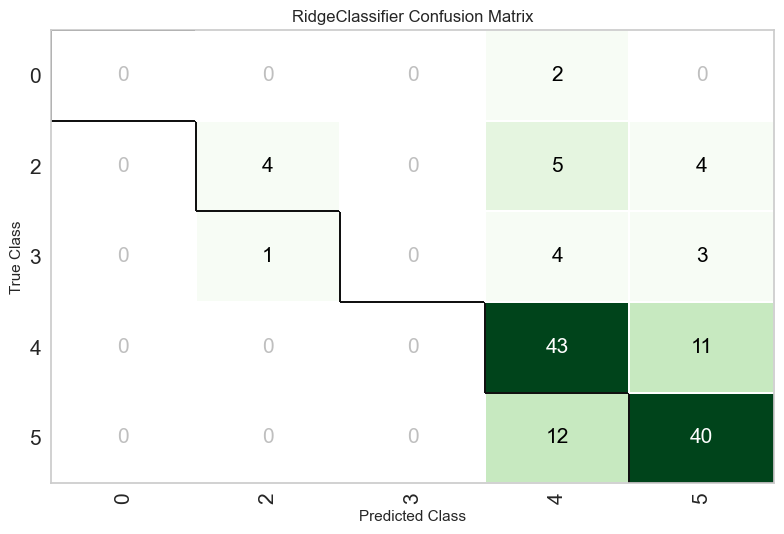

In [49]:
plot_model(best_model, plot = 'confusion_matrix')

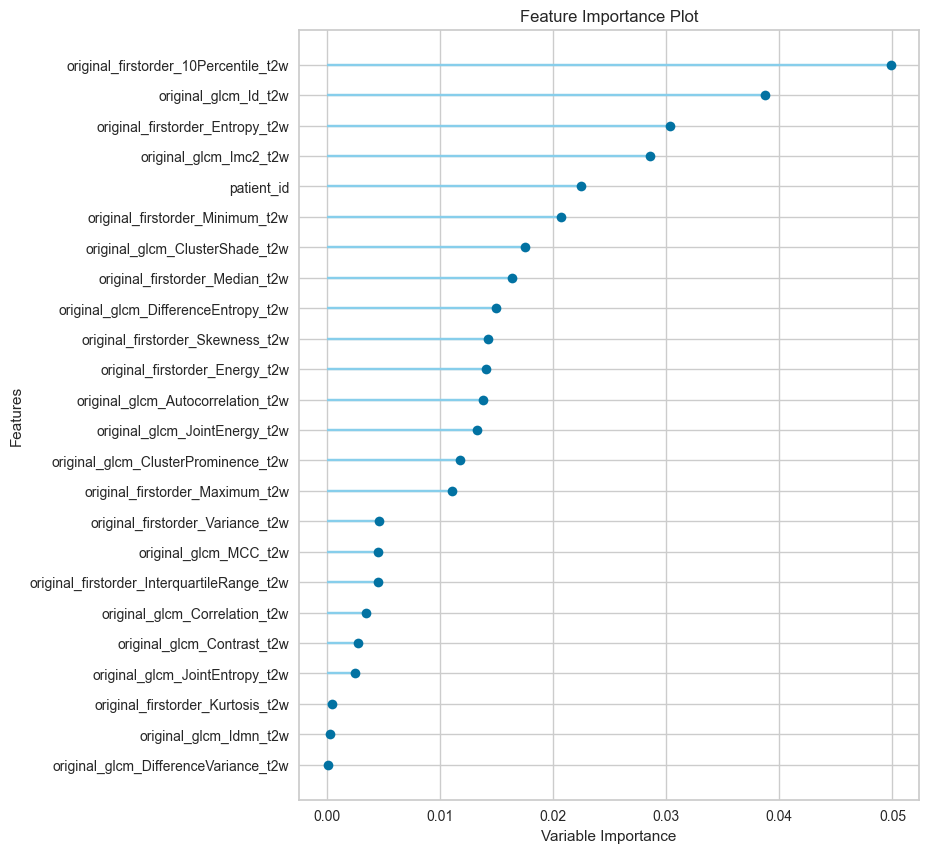

In [50]:
try:
    plot_model(best_model, plot = 'feature_all')
except:
    print('Feature importance not available for this model')

### Evaluation on the test data

In [51]:
final_best_model = finalize_model(best_model)
predictions = predict_model(final_best_model, data = test, round = 3, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.578,0,0.318,0.549,0.547,0.294,0.301


In [52]:
print("classification report")
print(classification_report(predictions[target], predictions['Label']))
# Format the confusion matrix to be more readable 
cm = confusion_matrix(predictions[target], predictions['Label'])
pd.DataFrame(cm, columns=[f'Predicted {i}' for i in range(cm.shape[0])], index=[f'Actual {i}' for i in range(cm.shape[1])])

classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.14      0.06      0.08        18
           3       0.50      0.11      0.18         9
           4       0.68      0.67      0.68        79
           5       0.50      0.75      0.60        40

    accuracy                           0.58       147
   macro avg       0.36      0.32      0.31       147
weighted avg       0.55      0.58      0.55       147



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,0,0,1,0
Actual 1,0,1,1,9,7
Actual 2,0,0,1,5,3
Actual 3,0,6,0,53,20
Actual 4,0,0,0,10,30


### TZ 

In [53]:
target = 'lesion_t2w_tz'

train = prepare_input(train_metadata, t2w_features, target)
test = prepare_input(test_metadata, t2w_features, target)

In [54]:
clfs = setup_pycaret(train, target)

,Description,Value
0,session_id,1991
1,Target,lesion_t2w_tz
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(451, 44)"
5,Missing Values,True
6,Numeric Features,43
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [55]:
print('Removed features:\n\t', ', '.join(set(train.columns)-set(get_config('X_train').columns)))

print('\n\nSelected features:\n\t', ', '.join(set(get_config('X_train').columns)))

Removed features:
	 original_firstorder_TotalEnergy_t2w, original_firstorder_Variance_t2w, original_glcm_ClusterProminence_t2w, original_glcm_Id_t2w, original_firstorder_Entropy_t2w, original_glcm_SumSquares_t2w, original_glcm_InverseVariance_t2w, original_firstorder_RootMeanSquared_t2w, original_glcm_SumEntropy_t2w, original_firstorder_RobustMeanAbsoluteDeviation_t2w, lesion_t2w_tz, original_firstorder_Mean_t2w, original_glcm_Idn_t2w, original_glcm_Imc1_t2w, original_glcm_JointAverage_t2w, original_firstorder_MeanAbsoluteDeviation_t2w, original_glcm_DifferenceVariance_t2w, original_firstorder_90Percentile_t2w, original_firstorder_Maximum_t2w, original_glcm_Autocorrelation_t2w, original_glcm_DifferenceAverage_t2w, original_glcm_MaximumProbability_t2w


Selected features:
	 original_glcm_JointEnergy_t2w, original_glcm_ClusterTendency_t2w, original_firstorder_10Percentile_t2w, original_glcm_Imc2_t2w, original_glcm_DifferenceEntropy_t2w, original_firstorder_Skewness_t2w, original_glcm_Con

In [56]:
top3 = compare_models(n_select=3, sort='Accuracy', include=considered_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6154,0.1587,0.4364,0.6041,0.5784,0.3699,0.3869,0.0080
ridge,Ridge Classifier,0.5807,0.0000,0.3807,0.5641,0.5317,0.2959,0.3198,0.0040
lda,Linear Discriminant Analysis,0.5423,0.1520,0.3648,0.5470,0.5111,0.2580,0.2742,0.0040
svm,SVM - Linear Kernel,0.5330,0.0000,0.3595,0.5539,0.5211,0.2743,0.2864,0.0250
qda,Quadratic Discriminant Analysis,0.4661,0.0808,0.3190,0.4990,0.4533,0.2612,0.2731,0.0050


In [57]:
tuned_top3 = [tune_model(i) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5312,0.0000,0.3714,0.4901,0.4674,0.2672,0.2972
1,0.5938,0.0000,0.4063,0.6521,0.5435,0.3500,0.3720
2,0.6562,0.0000,0.4184,0.6673,0.6306,0.3825,0.3914
3,0.5938,0.8288,0.3587,0.6388,0.5296,0.3900,0.4274
4,0.7188,0.0000,0.4262,0.7331,0.6794,0.3793,0.4011
5,0.5161,0.7516,0.3333,0.4923,0.4661,0.2780,0.2908
6,0.5484,0.0000,0.6099,0.6146,0.5712,0.2838,0.2919
7,0.5484,0.0000,0.3295,0.5434,0.5188,0.2426,0.2654
8,0.5484,0.0000,0.4444,0.4672,0.4929,0.2319,0.2513


In [58]:
best_model = automl(optimize='Accuracy')

In [59]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1991, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
#plot_model(best_model, plot = 'learning', groups='fold_group')

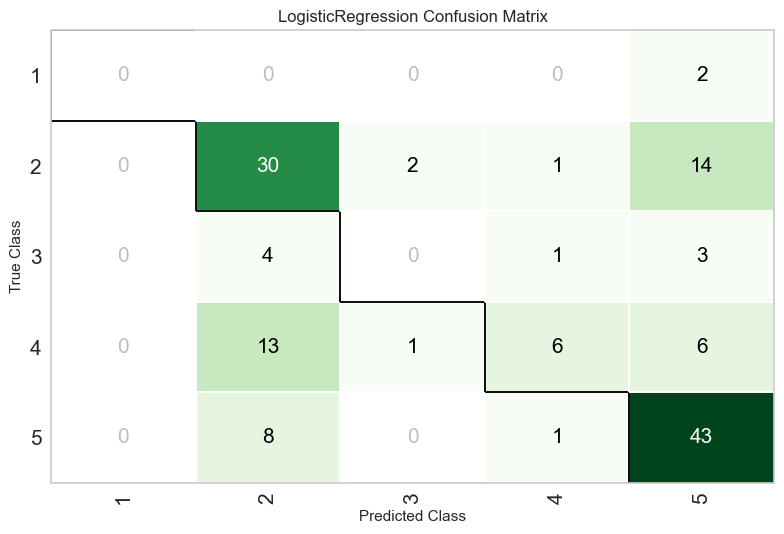

In [61]:
plot_model(best_model, plot = 'confusion_matrix')

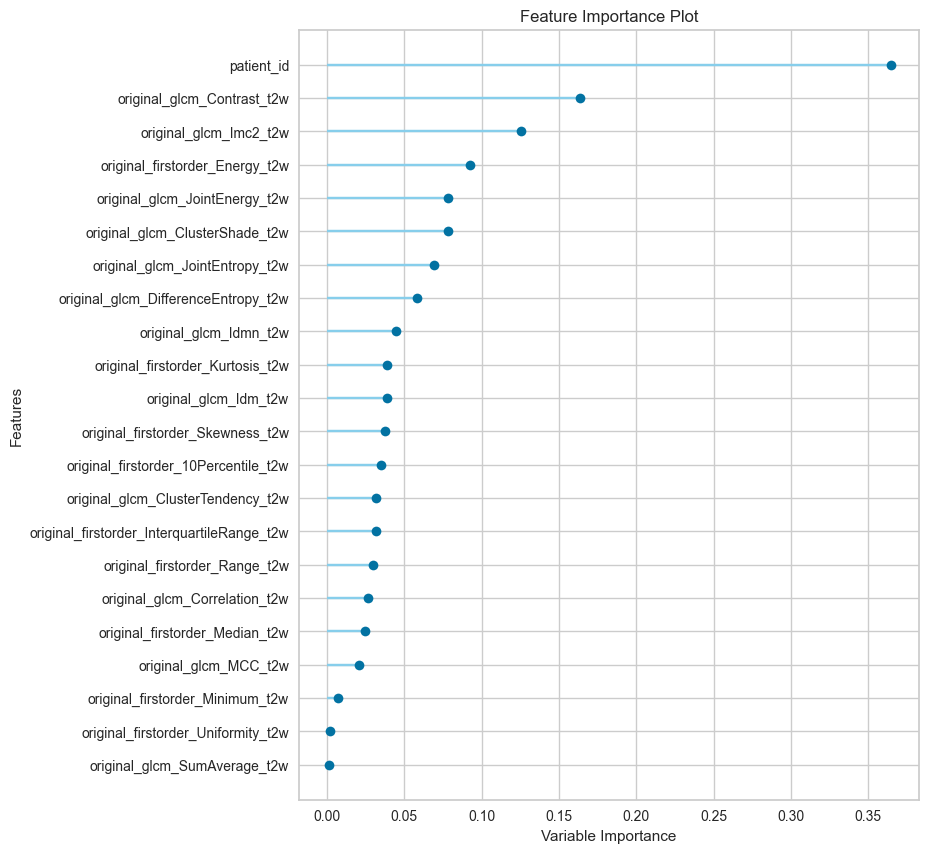

In [62]:
plot_model(best_model, plot = 'feature_all')

### Evaluation on the test data

In [63]:
final_best_model = finalize_model(best_model)
predictions = predict_model(final_best_model, data = test, round = 3, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.577,0,0.367,0.562,0.505,0.386,0.424


In [64]:
print("classification report")
print(classification_report(predictions[target], predictions['Label']))
# Format the confusion matrix to be more readable 
cm = confusion_matrix(predictions[target], predictions['Label'])
pd.DataFrame(cm, columns=[f'Predicted {i}' for i in range(cm.shape[0])], index=[f'Actual {i}' for i in range(cm.shape[1])])

classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.41      0.81      0.54        27
           3       0.00      0.00      0.00         8
           4       0.67      0.14      0.23        29
           5       0.75      0.88      0.81        43

    accuracy                           0.58       111
   macro avg       0.36      0.37      0.32       111
weighted avg       0.56      0.58      0.51       111



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,0,4,0,0,0
Actual 1,0,22,0,1,4
Actual 2,0,6,0,0,2
Actual 3,0,18,0,4,7
Actual 4,0,4,0,1,38


## Clinical Significance

In [65]:
target = 'TBx'

features = pd.merge(adc_features, hbv_features, on=idx_cols, how='inner')
features = pd.merge(features, t2w_features, on=idx_cols, how='outer')
features = pd.merge(features, dce_features, on=idx_cols, how='outer')

train = prepare_input(train_metadata, features, target)
test = prepare_input(test_metadata, features, target)


In [66]:
clfs = setup_pycaret(train, target)

,Description,Value
0,session_id,1991
1,Target,TBx
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4841, 170)"
5,Missing Values,True
6,Numeric Features,168
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [67]:
print('Removed features:\n\t', ', '.join(set(train.columns)-set(get_config('X_train').columns)))

print('\n\nSelected features:\n\t', ', '.join(set(get_config('X_train').columns)))

Removed features:
	 original_firstorder_MeanAbsoluteDeviation_dce, original_glcm_ClusterTendency_t2w, original_glcm_Idmn_hbv, original_firstorder_Variance_t2w, original_glcm_Imc2_t2w, original_glcm_Idn_adc, original_glcm_DifferenceEntropy_dce, original_glcm_Idm_t2w, original_glcm_Idm_adc, original_firstorder_RootMeanSquared_adc, original_glcm_JointAverage_dce, original_glcm_SumSquares_t2w, original_glcm_Contrast_hbv, original_glcm_Idm_dce, original_firstorder_Median_hbv, original_glcm_JointEntropy_hbv, original_firstorder_Energy_t2w, original_glcm_SumSquares_adc, original_firstorder_Uniformity_hbv, original_glcm_MCC_t2w, original_glcm_Contrast_dce, original_firstorder_MeanAbsoluteDeviation_t2w, original_glcm_SumEntropy_adc, original_glcm_DifferenceEntropy_hbv, original_glcm_SumAverage_t2w, original_glcm_DifferenceVariance_dce, original_firstorder_Minimum_hbv, original_glcm_MaximumProbability_dce, original_firstorder_Variance_adc, original_glcm_Id_t2w, original_glcm_JointAverage_hbv, or

In [68]:
top3 = compare_models(n_select=3, sort='AUC', include=considered_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9520,0.9932,0.9511,0.9575,0.9541,0.9037,0.9042,0.0510
lda,Linear Discriminant Analysis,0.9460,0.9890,0.9468,0.9509,0.9486,0.8917,0.8922,0.0280
qda,Quadratic Discriminant Analysis,0.5479,0.5429,0.6287,0.5773,0.5550,0.0865,0.0745,0.0210
ridge,Ridge Classifier,0.9476,0.0000,0.9477,0.9529,0.9501,0.8949,0.8953,0.0170
svm,SVM - Linear Kernel,0.9404,0.0000,0.9382,0.9491,0.9429,0.8805,0.8821,0.0240


In [69]:
tuned_top3 = [tune_model(i, optimize='AUC') for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9562,0.9931,0.9733,0.9432,0.9580,0.9122,0.9127
1,0.9505,0.9865,0.9769,0.9338,0.9549,0.9001,0.9012
2,0.9554,0.9948,0.9710,0.9460,0.9583,0.9103,0.9107
3,0.9582,0.9921,0.9829,0.9373,0.9596,0.9163,0.9174
4,0.9195,0.9910,0.9556,0.8958,0.9247,0.8385,0.8405
5,0.9540,0.9963,0.9583,0.9583,0.9583,0.9071,0.9071
6,0.9540,0.9920,0.9362,0.9778,0.9565,0.9078,0.9088
7,0.9770,0.9995,0.9773,0.9773,0.9773,0.9540,0.9540
8,0.9310,0.9941,0.9574,0.9184,0.9375,0.8607,0.8616


In [70]:
best_model = automl(optimize='AUC', use_holdout=True)

In [71]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1991, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
#plot_model(best_model, plot = 'learning', groups='fold_group')

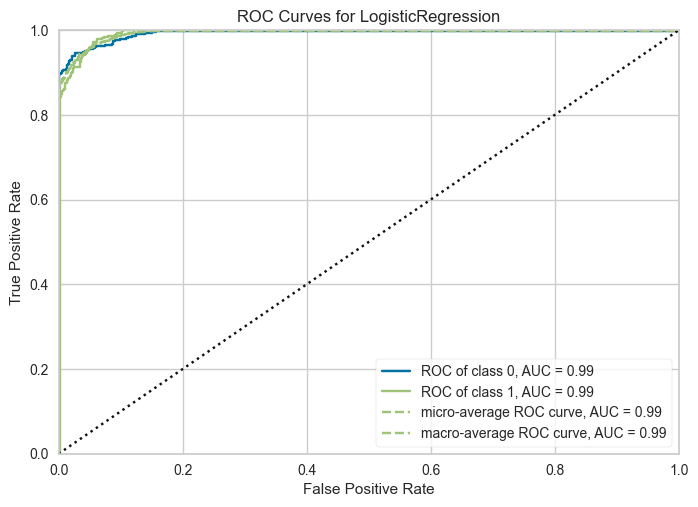

In [73]:
plot_model(best_model, plot = 'auc')

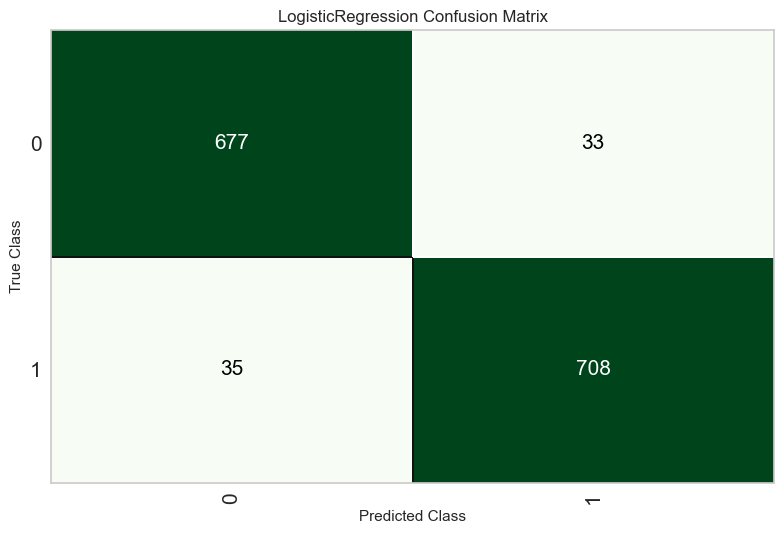

In [74]:
plot_model(best_model, plot = 'confusion_matrix')

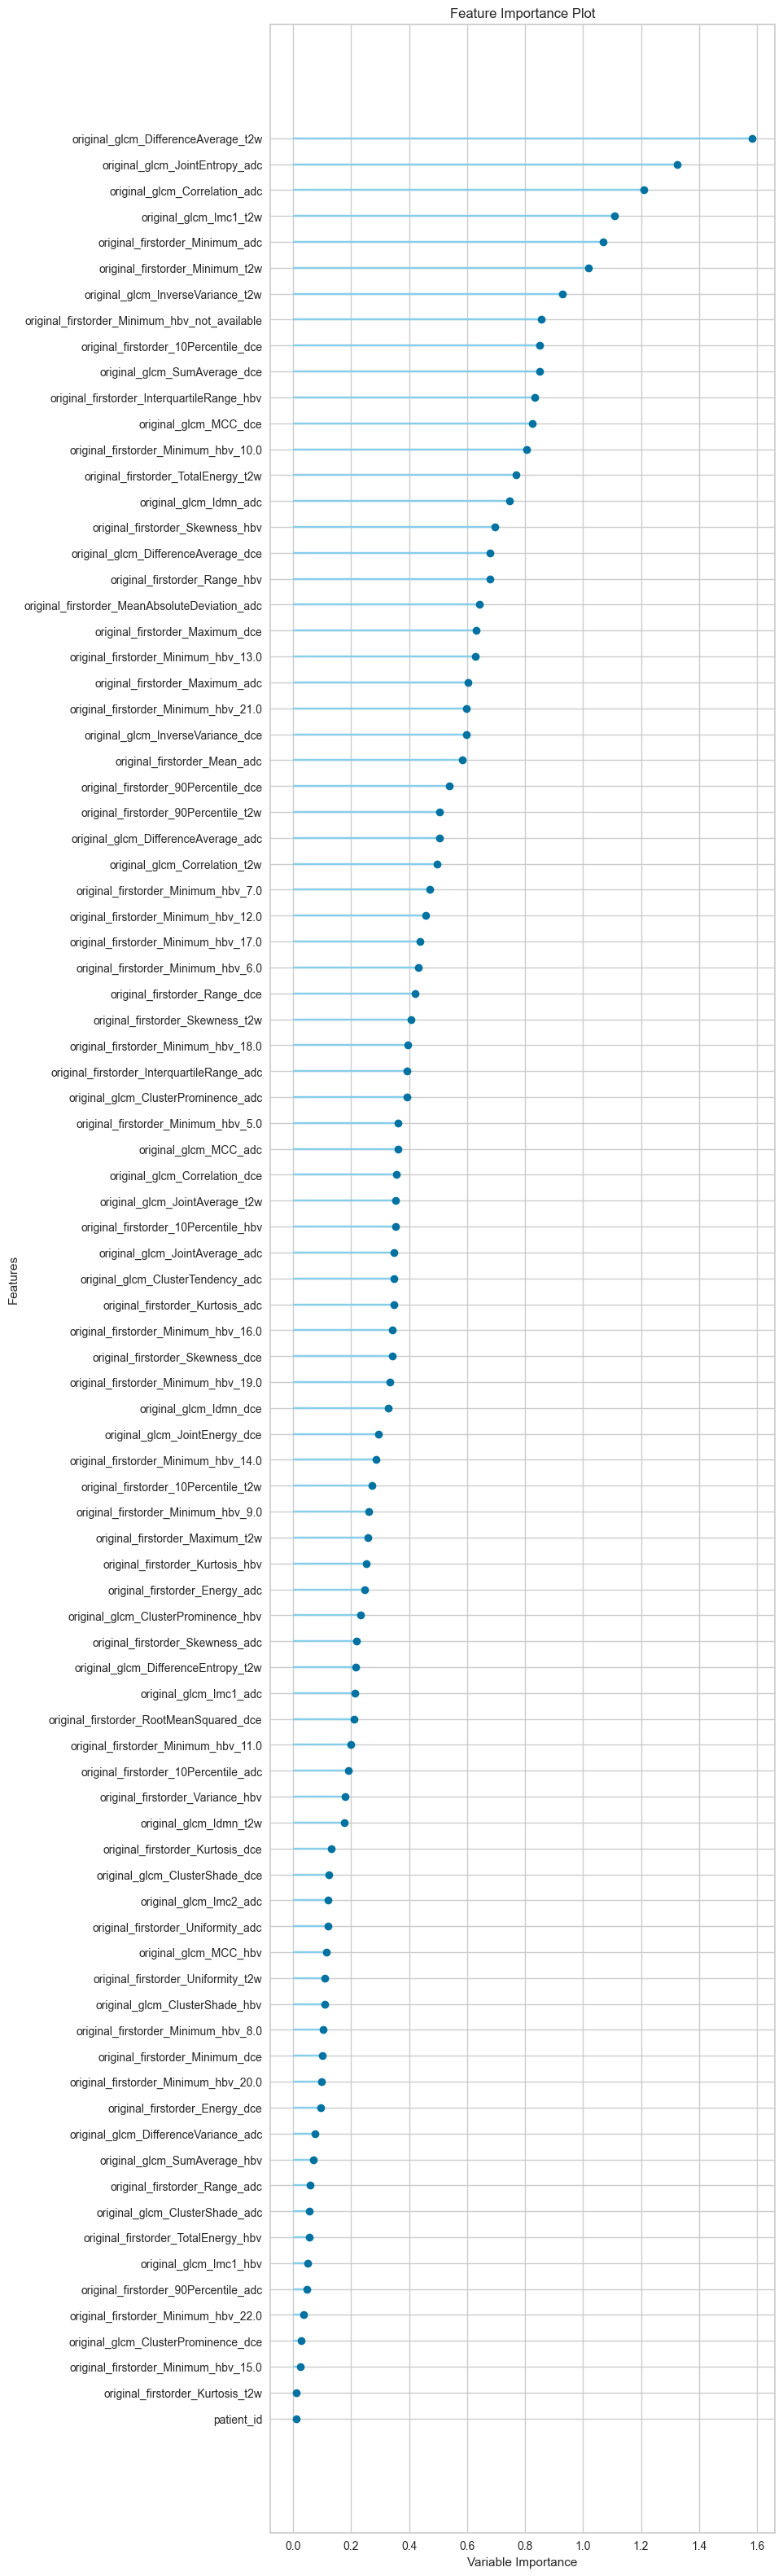

In [75]:
try:
    plot_model(best_model, plot = 'feature_all')
except:
    print('Feature importance not available for this model')

### Evaluation on the test data

In [76]:
final_best_model = finalize_model(best_model)
predictions = predict_model(final_best_model, data = test, round = 3, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.577,0.675,0.792,0.581,0.670,0.117,0.129


In [77]:
print("classification report")
print(classification_report(predictions[target], predictions['Label']))
# Format the confusion matrix to be more readable 
cm = confusion_matrix(predictions[target], predictions['Label'])
pd.DataFrame(cm, columns=[f'Predicted {i}' for i in range(cm.shape[0])], index=[f'Actual {i}' for i in range(cm.shape[1])])

classification report
              precision    recall  f1-score   support

           0       0.57      0.32      0.41       134
           1       0.58      0.79      0.67       159

    accuracy                           0.58       293
   macro avg       0.57      0.56      0.54       293
weighted avg       0.57      0.58      0.55       293



,Predicted 0,Predicted 1
Actual 0,43,91
Actual 1,33,126
